In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint  
from math import pi
from qutip import Options, sigmax, sigmaz, sesolve, mesolve, basis, expect, tensor, qeye, destroy, Qobj
from scipy.optimize import curve_fit
from schedule import run, generate_local_adiabatic_pulse, ramp_array, ramp, Schedule, find_eigen
import sympy as sp
from sympy.assumptions.refine import refine_abs, refine
from sympy import Q, Abs, Eq
from copy import deepcopy

d:\anaconda3\envs\qubit-reset\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


### 1.

In [2]:
g = 0.070 # GHz
dt = 0.01 # ns
unit = 2 * pi
y0 = -50.0 * g
y1 = +50.0 * g


def dy_dt(y, args):
    scale, g = args['scale'], args['g']
    dy_dt = scale * (1 / g) * (y ** 2 + 4 * g ** 2) ** 1.5
    return dy_dt


def num_generate_local_adiabatic_pulse(amp_init, amp_final, dy_dt, args, dt):
    seq = [amp_init]
    diff = seq[-1] - amp_final
    _y = amp_init
    while diff < 0:
        _y = seq[-1] + dy_dt(_y, args) * dt
        diff = _y - amp_final
        seq.append(_y)
    if abs(seq[-1] - amp_final) >= 1e-2:
        seq[-1] = amp_final
    else:
        pass
    seq = np.array(seq, dtype=float)
    return seq

In [3]:
scale1 = 0.1

args = {'g': g, 'y0': y0, 'yt': y1, 'scale': scale1}
yy1 = num_generate_local_adiabatic_pulse(y0, y1, dy_dt, args=args, dt=dt)
xx1 = np.linspace(0, len(yy1) * dt, len(yy1))

In [4]:
scale2 = 0.2

args = {'g': g, 'y0': y0, 'yt': y1, 'scale': scale2}
yy2 = num_generate_local_adiabatic_pulse(y0, y1, dy_dt, args=args, dt=dt)
xx2 = np.linspace(0, len(yy2) * dt, len(yy2))

In [5]:
scale3 = 0.4

args = {'g': g, 'y0': y0, 'yt': y1, 'scale': scale3}
yy3 = num_generate_local_adiabatic_pulse(y0, y1, dy_dt, args=args, dt=dt)
xx3 = np.linspace(0, len(yy3) * dt, len(yy3))

In [6]:
# linear

duration = xx1[-1]
yy4 = np.linspace(y0, y1, int(np.ceil(duration / dt)))
xx4 = np.linspace(0, len(yy4) * dt, len(yy4))


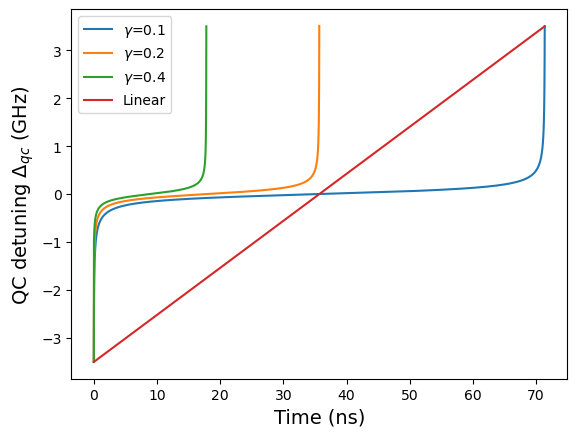

In [7]:
plt.plot(xx1, yy1, label=f'$\gamma$={scale1}')
plt.plot(xx2, yy2, label=f'$\gamma$={scale2}')
plt.plot(xx3, yy3, label=f'$\gamma$={scale3}')
plt.plot(xx4, yy4, label=f'Linear')

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'QC detuning $\Delta_{qc}$ (GHz)', fontsize=14)
plt.show()

In [8]:
# Device parameters, all parameters are in GHz or nanoseconds
fq = 3000e-3
fc0 = fq - y0
fct = fq - y1
alphaq = -195.591338e-3 # qubit 1 anharmonicity
alphac = -60e-3  # coupler anharmonicity
detunig_qc0 = fq - fc0

# Levels
qubit_levels = 3
coupler_levels = 3

# Operators
a = tensor(destroy(qubit_levels), qeye(coupler_levels))
c = tensor(qeye(qubit_levels), destroy(coupler_levels))

# Uncoupled Hamiltonian
H0 = fq * 2 * pi * a.dag() * a + 0.5 * alphaq * 2 * pi * a.dag() * a.dag() * a * a + fc0 * 2 * pi * c.dag() * c + 0.5 * alphac * 2 * pi * c.dag() * c.dag() * c * c 

# Interaction Hamiltonian
H1 = g * 2 * pi * (a.dag() * c + a * c.dag())

# Coupled Hamiltonian
H2 = H0 + H1

# Perturbation term for tuning up the coupler frequency
Hd = 2 * pi * c.dag() * c

In [9]:
psi10 = tensor(basis(qubit_levels, 1), basis(coupler_levels, 0))
psi01 = tensor(basis(qubit_levels, 0), basis(coupler_levels, 1))
psi20 = tensor(basis(qubit_levels, 2), basis(coupler_levels, 0))
psi02 = tensor(basis(qubit_levels, 0), basis(coupler_levels, 2))
psi11 = tensor(basis(qubit_levels, 1), basis(coupler_levels, 1))

proj10 = psi10 * psi10.dag()
proj01 = psi01 * psi01.dag()
proj20 = psi20 * psi20.dag()
proj02 = psi02 * psi02.dag()
proj11 = psi11 * psi11.dag()

# Eigenenergies and eigenstates
eigenenergies, eigenstates = H2.eigenstates()
psi_init_01, _, _ = find_eigen(psi01, eigenstates, eigenenergies)
psi_init_10, _, _ = find_eigen(psi10, eigenstates, eigenenergies)


In [10]:
H = [H2, [Hd, -yy1+fq-fc0]]
times = xx1

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals1, overlap1 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop1 = exp_vals1[0]

In [11]:
H = [H2, [Hd, -yy2+fq-fc0]]
times = xx2

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals2, overlap2 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop2 = exp_vals1[0]

In [12]:
H = [H2, [Hd, -yy3+fq-fc0]]
times = xx3

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals3, overlap3 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop3 = exp_vals1[0]

In [13]:
H = [H2, [Hd, -yy4+fq-fc0]]
times = xx4

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]
exp_vals4, overlap4 = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
pop4 = exp_vals1[0]

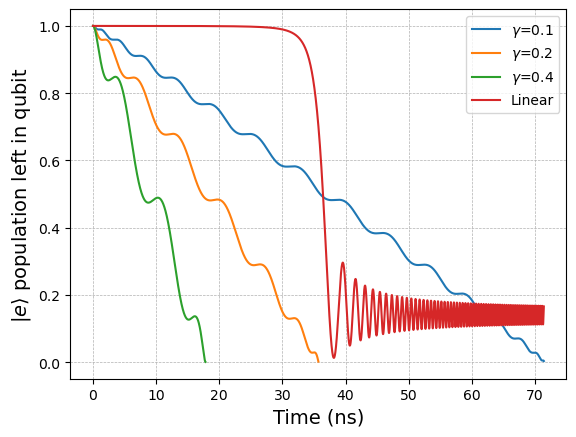

In [14]:
plt.plot(xx1, exp_vals1[0], label=f'$\gamma$={scale1}')
plt.plot(xx2, exp_vals2[0], label=f'$\gamma$={scale2}')
plt.plot(xx3, exp_vals3[0], label=f'$\gamma$={scale3}')
plt.plot(xx4, exp_vals4[0], label=f'Linear')

plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'$|e\rangle$ population left in qubit', fontsize=14)

plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [15]:
exp_vals3[0][-1]

0.0007331777118345154

In [16]:
overlap4[overlap4<0.1]=0.8612831155970658

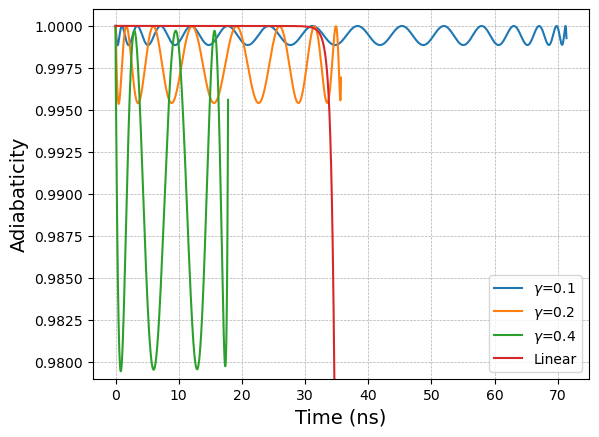

In [17]:
step = 1
plt.plot(xx1[::step], overlap1[::step], label=f'$\gamma$={scale1}')
plt.plot(xx2[::step], overlap2[::step], label=f'$\gamma$={scale2}')
plt.plot(xx3[::step], overlap3[::step], label=f'$\gamma$={scale3}')
plt.plot(xx4[::step], overlap4[::step], label=f'Linear')

plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'Adiabaticity', fontsize=14)
plt.ylim(0.979, 1.001)
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

2.

In [18]:
g_paras = [0.02, 0.07, 0.10, 0.15, 1.0]
duration = 35
dt = 0.1
g = 0.070 # GHz
unit = 2 * pi
y0 = -50.0 * g
y1 = +25.0 * g



In [19]:

flux1 = generate_local_adiabatic_pulse(g=g_paras[0], T=duration, y0=y0, yt=y1, dt=dt)
flux2 = generate_local_adiabatic_pulse(g=g_paras[1], T=duration, y0=y0, yt=y1, dt=dt)
flux3 = generate_local_adiabatic_pulse(g=g_paras[2], T=duration, y0=y0, yt=y1, dt=dt)
flux4 = generate_local_adiabatic_pulse(g=g_paras[3], T=duration, y0=y0, yt=y1, dt=dt)
flux5 = generate_local_adiabatic_pulse(g=g_paras[4], T=duration, y0=y0, yt=y1, dt=dt)


times = np.linspace(0, duration, len(flux1))


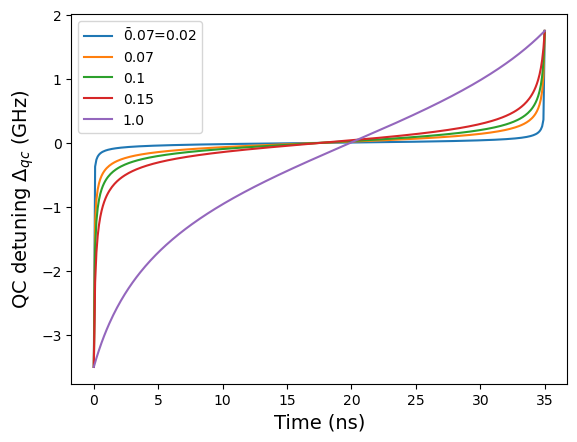

In [20]:
plt.plot(times, flux1, label=fr'$\bar{g}$={g_paras[0]}')
plt.plot(times, flux2, label=fr'{g_paras[1]}')
plt.plot(times, flux3, label=fr'{g_paras[2]}')
plt.plot(times, flux4, label=fr'{g_paras[3]}')
plt.plot(times, flux5, label=fr'{g_paras[4]}')

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel(r'QC detuning $\Delta_{qc}$ (GHz)', fontsize=14)
plt.show()

In [21]:

expt_op = [psi_init_10 * psi_init_10.dag(), psi_init_01 * psi_init_01.dag()]

exps, overlaps = [], []

for flux in [flux1, flux2, flux3, flux4, flux5]:
    H = [H2, [Hd, -flux+fq-fc0]]
    exp, overlap = run(H0=H[0], Ht=H[1], times=times, psi_init=psi_init_10, e_ops=expt_op, eigen_idx=1)
    exps.append(exp)
    overlaps.append(overlap)

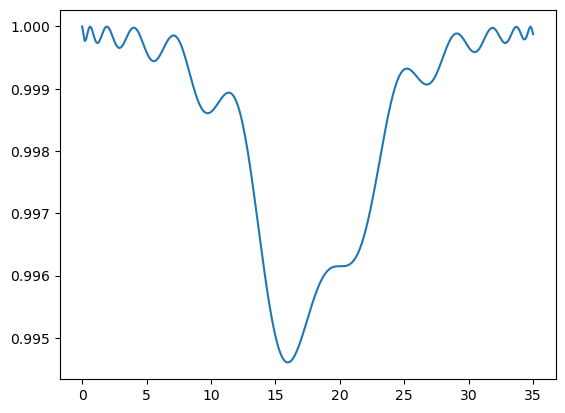

In [22]:
# plt.plot(times, overlaps[0])
# plt.plot(times, overlaps[1])
# plt.plot(times, overlaps[2])
plt.plot(times, overlaps[3])
# plt.plot(times, overlaps[4])


plt.show()

In [23]:
overlaps[3][-1]

0.9998768087779364

# 3LS spectrum

# 3LS spectrum

In [24]:
def ham_3ls(omega1, omega2, g, alpha1, alpha2):
    h_mat = np.array([
    [2 * omega1 + alpha1, g, 0],
    [g, omega1 + omega2, g],
    [0, g, 2 * omega2 + alpha2]
], dtype=complex)
    return h_mat


def ham_tls2(freq_c, freq_q, g):
    h_mat = np.array([
    [freq_q, g],
    [g, freq_c] 
    ], dtype=complex)
    return h_mat

def ham_tls(detuning, g):
    h_mat = np.array([
        [detuning, g],
        [g, -detuning] 
    ], dtype=complex)
    return h_mat

def npad_rot(h, j, k):
    delta_jk = 0.5 * (h[j, j] - h[k, k])
    g_jk = h[j, k]
    theta = np.arctan(g_jk / delta_jk)
    c_jk = np.cos(theta / 2)
    s_jk = np.sin(theta / 2)
    u_jk = np.zeros_like(h, dtype=complex)
    np.fill_diagonal(u_jk, 1. + 0j)
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.conj().T
    if h_pr[j, j] > h_pr[k, k]:
        h_pr[:, [j, k]] = h_pr[:, [k, j]]
        h_pr[[j, k], :] = h_pr[[k, j], :]
    return h_pr

def npad_rot_sym(h, j, k):
    delta_jk =  (h[j, j] - h[k, k]) / 2
    g_jk = h[j, k]
    theta = sp.atan(g_jk / delta_jk)
    c_jk = sp.cos(theta / 2)
    s_jk = sp.sin(theta / 2)
    u_jk = sp.eye(h.shape[0], h.shape[1])
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.T
    # if h_pr[j, j] > h_pr[k, k]:
    #     h_pr[:, [j, k]] = h_pr[:, [k, j]]
    #     h_pr[[j, k], :] = h_pr[[k, j], :]
    return h_pr

## Symbol NPAD for anharm=0

In [25]:
wq = sp.Symbol('wq', positive=True, real=True, dtype=float)
wc = sp.Symbol('wc', positive=True, real=True, dtype=float)
g = sp.Symbol('g', positive=True, real=True, dtype=float)
a = sp.Symbol('α', positive=False, real=True, dtype=float)
b = sp.Symbol('β', positive=False, real=True, dtype=float)
delta = sp.Symbol('Δ', real=True, dtype=float)
gamma = sp.Symbol('γ', real=True, positive=False, dtype=float)
# g_val = 50
# a_val = -200
# h0 = sp.Matrix([
# [2*wq + a,      g,            0],
# [g,       wq + wc,            g],
# [0,            g,    2*wc]])


# h0 = sp.Matrix([
# [delta, g],
# [g,  -delta]])


h0 = sp.Matrix([
[delta,      g,            0],
[g,       -delta,            g],
[0,            g,    -3*delta]])


h0

Matrix([
[Δ,  g,    0],
[g, -Δ,    g],
[0,  g, -3*Δ]])

\begin{align}
H_0 = \begin{pmatrix}
2\omega_q + \alpha & g & 0 \\ g & \omega_q + \omega_c & g \\ 0 & g & 2\omega_c
\end{pmatrix}
\end{align}

\begin{align}
H_0 = \begin{pmatrix}
\Delta & g & 0 \\ g & -\Delta & g \\ 0 & g & \alpha - 3\Delta
\end{pmatrix}
\end{align}

$$
\Delta = \frac{1}{2}(\omega_q - \omega_c)
$$

In [26]:
h_tls = sp.Matrix([
[delta ,      g],
[g,       -delta],
])

In [27]:
h_tls_pr = npad_rot_sym(h_tls, 0, 1)
h_tls_pr = h_tls_pr.applyfunc(sp.simplify)
h_tls_pr

Matrix([
[g**2*Abs(Δ)/(Δ*sqrt(g**2 + Δ**2)) + Δ/sqrt(g**2/Δ**2 + 1),         g/sqrt(g**2/Δ**2 + 1) - g*Abs(Δ)/sqrt(g**2 + Δ**2)],
[       g/sqrt(g**2/Δ**2 + 1) - g*Abs(Δ)/sqrt(g**2 + Δ**2), -g**2*Abs(Δ)/(Δ*sqrt(g**2 + Δ**2)) - Δ/sqrt(g**2/Δ**2 + 1)]])

First NPAD

In [28]:
h1 = npad_rot_sym(h0, 0, 1)
h1

Matrix([
[ (g*sin(atan(g/Δ)/2) + Δ*cos(atan(g/Δ)/2))*cos(atan(g/Δ)/2) + (g*cos(atan(g/Δ)/2) - Δ*sin(atan(g/Δ)/2))*sin(atan(g/Δ)/2), -(g*sin(atan(g/Δ)/2) + Δ*cos(atan(g/Δ)/2))*sin(atan(g/Δ)/2) + (g*cos(atan(g/Δ)/2) - Δ*sin(atan(g/Δ)/2))*cos(atan(g/Δ)/2), g*sin(atan(g/Δ)/2)],
[(-g*sin(atan(g/Δ)/2) - Δ*cos(atan(g/Δ)/2))*sin(atan(g/Δ)/2) + (g*cos(atan(g/Δ)/2) - Δ*sin(atan(g/Δ)/2))*cos(atan(g/Δ)/2), (-g*sin(atan(g/Δ)/2) - Δ*cos(atan(g/Δ)/2))*cos(atan(g/Δ)/2) - (g*cos(atan(g/Δ)/2) - Δ*sin(atan(g/Δ)/2))*sin(atan(g/Δ)/2), g*cos(atan(g/Δ)/2)],
[                                                                                                      g*sin(atan(g/Δ)/2),                                                                                                       g*cos(atan(g/Δ)/2),               -3*Δ]])

In [29]:
h1 = h1.applyfunc(sp.simplify)

In [30]:
h100 = sp.simplify(h1[0, 0])
h101 = sp.simplify(h1[0, 1])
h111 = sp.simplify(h1[1, 1])
h100

sqrt(g**2 + Δ**2)*Abs(Δ)/Δ

In [31]:
h1[0, 1] = 0.0
h1[1, 0] = 0.0
h1[1, 1] = h111
h1[0, 0] = h100

h1

Matrix([
[sqrt(g**2 + Δ**2)*Abs(Δ)/Δ,                           0, g*sin(atan(g/Δ)/2)],
[                         0, -sqrt(g**2 + Δ**2)*Abs(Δ)/Δ, g*cos(atan(g/Δ)/2)],
[        g*sin(atan(g/Δ)/2),          g*cos(atan(g/Δ)/2),               -3*Δ]])

In [32]:
h1_diag = h1.diagonal()

In [33]:
g_val = 50e-3
a_val = -0.e-3
delta_sweep = np.linspace(-10 * g_val, 10 * g_val, 100)


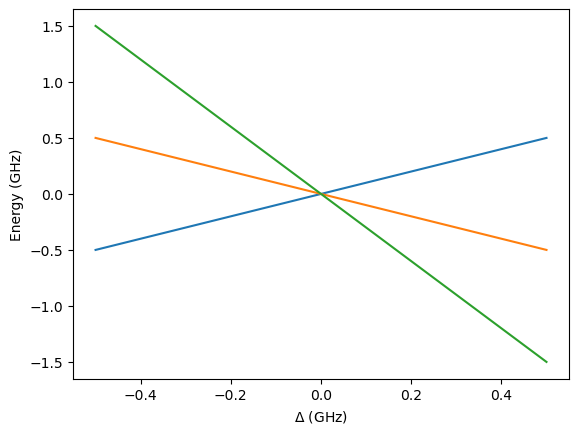

In [34]:
diag_exprs = h0.diagonal()
energies0 = [diag_exprs[0].subs({g: g_val, delta: d}) for d in delta_sweep]
energies1 = [diag_exprs[1].subs({g: g_val, delta: d}) for d in delta_sweep]
energies2 = [diag_exprs[2].subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]

# for i in range(len(energies0)):
#     if energies0[i] > energies1[i]:
#         temp = energies1[i]
#         energies1[i] = energies0[i]
#         energies0[i] = temp

plt.plot(delta_sweep, energies0)
plt.plot(delta_sweep, energies1)
plt.plot(delta_sweep, energies2)



plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Energy (GHz)')

plt.show()

In [35]:

# expr_sub = {g: g_val, delta: np.linspace(-10 * g_val, 10 * g_val, 100)}

diag_exprs = h1.diagonal()
energies0 = [diag_exprs[0].subs({g: g_val, delta: d}) for d in delta_sweep]
energies1 = [diag_exprs[1].subs({g: g_val, delta: d}) for d in delta_sweep]
energies2 = [diag_exprs[2].subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]

for i in range(len(energies0)):
    if energies0[i] > energies1[i]:
        temp = energies1[i]
        energies1[i] = energies0[i]
        energies0[i] = temp

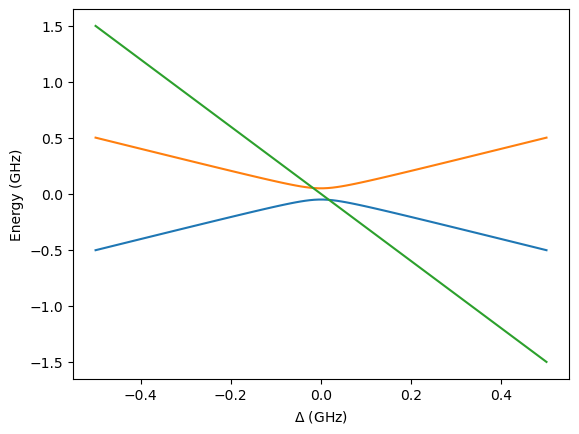

In [36]:
plt.plot(delta_sweep, energies0)
plt.plot(delta_sweep, energies1)
plt.plot(delta_sweep, energies2)

# plt.plot(delta_sweep, delta_sweep, '--')
# plt.plot(delta_sweep, -delta_sweep, '--')


plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Energy (GHz)')

plt.show()

Second NPAD

In [37]:
h1

Matrix([
[sqrt(g**2 + Δ**2)*Abs(Δ)/Δ,                           0, g*sin(atan(g/Δ)/2)],
[                         0, -sqrt(g**2 + Δ**2)*Abs(Δ)/Δ, g*cos(atan(g/Δ)/2)],
[        g*sin(atan(g/Δ)/2),          g*cos(atan(g/Δ)/2),               -3*Δ]])

In [38]:
E1 = sp.Symbol('E1', real=True)
s1 = sp.Symbol('s1', real=True)
c1 = sp.Symbol('c1', real=True)
E2 = sp.Symbol('E2', real=True)

s1_delta_sub = (s1, sp.sin(sp.atan(g/delta)/2))
c1_delta_sub = (c1, sp.cos(sp.atan(g/delta)/2))

delta_s1_sub = (sp.sin(sp.atan(g/delta)/2), s1)
delta_c1_sub = (sp.cos(sp.atan(g/delta)/2), c1)

# Eq(s1, sp.sin(sp.atan(g/delta)/2))
# Eq(c1, sp.cos(sp.atan(g/delta)/2))


h1_sim = sp.Matrix([
[h1[0, 0],      0,           s1 * g],
[0,       h1[1, 1],         c1 * g],
[s1 * g,          c1 * g,    h1[2, 2]]])
h1_sim


Matrix([
[sqrt(g**2 + Δ**2)*Abs(Δ)/Δ,                           0, g*s1],
[                         0, -sqrt(g**2 + Δ**2)*Abs(Δ)/Δ, c1*g],
[                      g*s1,                        c1*g, -3*Δ]])

In [39]:
h1_sim.subs([delta_s1_sub, delta_c1_sub])

Matrix([
[sqrt(g**2 + Δ**2)*Abs(Δ)/Δ,                           0, g*s1],
[                         0, -sqrt(g**2 + Δ**2)*Abs(Δ)/Δ, c1*g],
[                      g*s1,                        c1*g, -3*Δ]])

\begin{align}
s_1 = \sin\left(\frac{\arctan(g/\Delta)}{2}\right) \\
c_1 = \cos\left(\frac{\arctan(g/\Delta)}{2}\right)
\end{align}

In [40]:
# shift
# E1 = sp.Symbol('E1', real=True)
# s01 = sp.Symbol('s01', real=True)
# c01 = sp.Symbol('c01', real=True)
# E2 = sp.Symbol('E2', real=True)
# delta2 = sp.Symbol('Δ2')

# h1_input = sp.Matrix([
# [3 * E1/2 - E2 / 2,      0,           s01 * g],
# [0,       delta2,         c01 * g],
# [s01 * g,          c01 * g,    -delta2]])
# h1_input


Delta < 0

In [41]:
h1_sim

Matrix([
[sqrt(g**2 + Δ**2)*Abs(Δ)/Δ,                           0, g*s1],
[                         0, -sqrt(g**2 + Δ**2)*Abs(Δ)/Δ, c1*g],
[                      g*s1,                        c1*g, -3*Δ]])

$$
\Delta <0
$$

$\Delta_2$:

\begin{equation}
shift = \frac{-3\Delta-\sqrt{\Delta^2+g^2}}{2}
\end{equation}

\begin{align}
\Delta_2 &= -\sqrt{\Delta^2 + g ^ 2} - \frac{-3\Delta-\sqrt{\Delta^2+g^2}}{2} \\
&= \frac{1}{2}(3\Delta - \sqrt{\Delta^2 + g^2})
\end{align}

\begin{equation}
\delta_2 = \sqrt{\Delta^2 + g^2} - shift
\end{equation}


\begin{equation}
shift = \frac{\alpha-3\Delta-\sqrt{\Delta^2+g^2}}{2}
\end{equation}

$H_1$:
\begin{equation}
H_1 = \begin{pmatrix}
\Delta_2 && 0 && g s_{1} \\
0 && \delta_2 && c_{1} g \\
gs_{1} && c_{1}g && -\Delta_2\\
\end{pmatrix}
\end{equation}

In [42]:
delta2 = sp.Symbol('Δ2', real=True)
del2 = sp.Symbol('δ2', real=True)
shift2 = sp.eye(3) * (-3 * delta - sp.sqrt(delta ** 2 + g ** 2)) / 2
h1_delta_neg_shifted = h1_sim - shift2
delta2_sub = ((3 * delta - sp.sqrt(delta ** 2 + g ** 2)) / 2, delta2)
del2_sub = ((3 * sp.sqrt(delta ** 2 + g ** 2) + 3 * delta) / 2, del2)
del2_delta_sub = (del2, (3 * sp.sqrt(delta ** 2 + g ** 2) + 3 * delta) / 2)
delta2_delta_sub = (delta2, (3 * delta - sp.sqrt(delta ** 2 + g ** 2)) / 2)
h1_input = h1_delta_neg_shifted.subs([delta2_sub, del2_sub])

In [43]:
h1_delta_neg = h1_sim.applyfunc(lambda elem: refine(elem, Q.negative(delta)))
h1_delta_neg

Matrix([
[-sqrt(g**2 + Δ**2),                 0, g*s1],
[                 0, sqrt(g**2 + Δ**2), c1*g],
[              g*s1,              c1*g, -3*Δ]])

In [44]:
h1_delta_neg_shifted = h1_delta_neg - shift2
h1_delta_neg_shifted

Matrix([
[3*Δ/2 - sqrt(g**2 + Δ**2)/2,                             0,                         g*s1],
[                          0, 3*Δ/2 + 3*sqrt(g**2 + Δ**2)/2,                         c1*g],
[                       g*s1,                          c1*g, -3*Δ/2 + sqrt(g**2 + Δ**2)/2]])

In [45]:
h1_delta_neg_input = h1_delta_neg_shifted.subs([delta2_sub, del2_sub])
h1_delta_neg_input

Matrix([
[  Δ2,    0, g*s1],
[   0,   δ2, c1*g],
[g*s1, c1*g,  -Δ2]])

In [46]:
h2_delta_neg = npad_rot_sym(h1_delta_neg_input, 0, 2)
h2_delta_neg

Matrix([
[ (g*s1*sin(atan(g*s1/Δ2)/2) + Δ2*cos(atan(g*s1/Δ2)/2))*cos(atan(g*s1/Δ2)/2) + (g*s1*cos(atan(g*s1/Δ2)/2) - Δ2*sin(atan(g*s1/Δ2)/2))*sin(atan(g*s1/Δ2)/2), c1*g*sin(atan(g*s1/Δ2)/2), -(g*s1*sin(atan(g*s1/Δ2)/2) + Δ2*cos(atan(g*s1/Δ2)/2))*sin(atan(g*s1/Δ2)/2) + (g*s1*cos(atan(g*s1/Δ2)/2) - Δ2*sin(atan(g*s1/Δ2)/2))*cos(atan(g*s1/Δ2)/2)],
[                                                                                                                               c1*g*sin(atan(g*s1/Δ2)/2),                        δ2,                                                                                                                                c1*g*cos(atan(g*s1/Δ2)/2)],
[(-g*s1*sin(atan(g*s1/Δ2)/2) - Δ2*cos(atan(g*s1/Δ2)/2))*sin(atan(g*s1/Δ2)/2) + (g*s1*cos(atan(g*s1/Δ2)/2) - Δ2*sin(atan(g*s1/Δ2)/2))*cos(atan(g*s1/Δ2)/2), c1*g*cos(atan(g*s1/Δ2)/2), (-g*s1*sin(atan(g*s1/Δ2)/2) - Δ2*cos(atan(g*s1/Δ2)/2))*cos(atan(g*s1/Δ2)/2) - (g*s1*cos(atan(g*s1/Δ2)/2) - Δ2*sin(atan(g*s1/Δ2)/2))*sin

In [47]:
h2_delta_neg = h2_delta_neg.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_neg = h2_delta_neg.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_neg

Matrix([
[sqrt(g**2*s1**2 + Δ2**2)*Abs(Δ2)/Δ2, c1*g*sin(atan(g*s1/Δ2)/2),                                    0],
[          c1*g*sin(atan(g*s1/Δ2)/2),                        δ2,            c1*g*cos(atan(g*s1/Δ2)/2)],
[                                  0, c1*g*cos(atan(g*s1/Δ2)/2), -sqrt(g**2*s1**2 + Δ2**2)*Abs(Δ2)/Δ2]])

In [48]:
energy0_delta_neg_expr = sp.simplify(refine(h2_delta_neg[2, 2], Q.positive(delta2)))
energy0_delta_neg_expr = energy0_delta_neg_expr.subs([s1_delta_sub, delta2_delta_sub])
energy0_delta_neg_expr

-sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)

In [49]:
energy1_delta_neg_expr = sp.simplify(refine(h2_delta_neg[0, 0], Q.positive(delta2)))
energy1_delta_neg_expr = energy1_delta_neg_expr.subs([s1_delta_sub, delta2_delta_sub])
energy1_delta_neg_expr

sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)

In [50]:
energy2_delta_neg_expr = sp.simplify(refine(h2_delta_neg[1, 1], Q.positive(delta2)))
energy2_delta_neg_expr = energy2_delta_neg_expr.subs([del2_delta_sub])
energy2_delta_neg_expr

3*Δ/2 + 3*sqrt(g**2 + Δ**2)/2

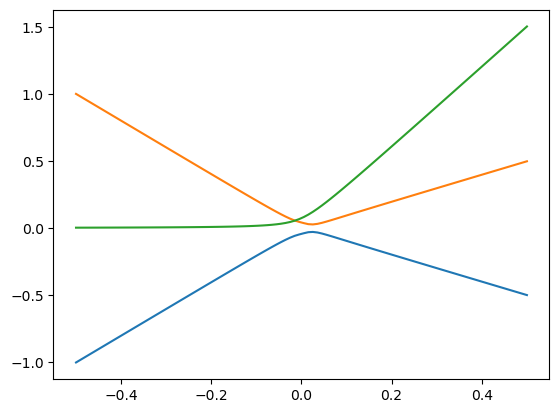

In [51]:
delta_sweep = np.linspace(-10 * g_val, 10 * g_val, 100)

energies0_delta_neg_sym = [energy0_delta_neg_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_delta_neg_sym = [energy1_delta_neg_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies2_delta_neg_sym = [energy2_delta_neg_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


# for i in range(len(energies0)):
#     if energies0[i] > energies1[i]:
#         temp = energies1[i]
#         energies1[i] = energies0[i]
#         energies0[i] = temp
plt.plot(delta_sweep, energies0_delta_neg_sym)
plt.plot(delta_sweep, energies1_delta_neg_sym)
plt.plot(delta_sweep, energies2_delta_neg_sym)


plt.show()

### $\Delta > 0$

In [52]:
h1_delta_pos = h1_sim.applyfunc(lambda elem: refine(elem, Q.positive(delta)))
h1_delta_pos

Matrix([
[sqrt(g**2 + Δ**2),                  0, g*s1],
[                0, -sqrt(g**2 + Δ**2), c1*g],
[             g*s1,               c1*g, -3*Δ]])

In [53]:
h1_delta_pos_shifted = h1_delta_pos - shift2
h1_delta_pos_shifted

Matrix([
[3*Δ/2 + 3*sqrt(g**2 + Δ**2)/2,                           0,                         g*s1],
[                            0, 3*Δ/2 - sqrt(g**2 + Δ**2)/2,                         c1*g],
[                         g*s1,                        c1*g, -3*Δ/2 + sqrt(g**2 + Δ**2)/2]])

In [54]:
h1_delta_neg_shifted

Matrix([
[3*Δ/2 - sqrt(g**2 + Δ**2)/2,                             0,                         g*s1],
[                          0, 3*Δ/2 + 3*sqrt(g**2 + Δ**2)/2,                         c1*g],
[                       g*s1,                          c1*g, -3*Δ/2 + sqrt(g**2 + Δ**2)/2]])

In [55]:
h1_delta_pos_input = h1_delta_pos_shifted.subs([delta2_sub, del2_sub])
h1_delta_pos_input

Matrix([
[  δ2,    0, g*s1],
[   0,   Δ2, c1*g],
[g*s1, c1*g,  -Δ2]])

In [56]:
h2_delta_pos = npad_rot_sym(h1_delta_pos_input, 1, 2)
h2_delta_pos

Matrix([
[                       δ2,                                                                                                                                g*s1*sin(atan(c1*g/Δ2)/2),                                                                                                                                g*s1*cos(atan(c1*g/Δ2)/2)],
[g*s1*sin(atan(c1*g/Δ2)/2),  (c1*g*sin(atan(c1*g/Δ2)/2) + Δ2*cos(atan(c1*g/Δ2)/2))*cos(atan(c1*g/Δ2)/2) + (c1*g*cos(atan(c1*g/Δ2)/2) - Δ2*sin(atan(c1*g/Δ2)/2))*sin(atan(c1*g/Δ2)/2), -(c1*g*sin(atan(c1*g/Δ2)/2) + Δ2*cos(atan(c1*g/Δ2)/2))*sin(atan(c1*g/Δ2)/2) + (c1*g*cos(atan(c1*g/Δ2)/2) - Δ2*sin(atan(c1*g/Δ2)/2))*cos(atan(c1*g/Δ2)/2)],
[g*s1*cos(atan(c1*g/Δ2)/2), (-c1*g*sin(atan(c1*g/Δ2)/2) - Δ2*cos(atan(c1*g/Δ2)/2))*sin(atan(c1*g/Δ2)/2) + (c1*g*cos(atan(c1*g/Δ2)/2) - Δ2*sin(atan(c1*g/Δ2)/2))*cos(atan(c1*g/Δ2)/2), (-c1*g*sin(atan(c1*g/Δ2)/2) - Δ2*cos(atan(c1*g/Δ2)/2))*cos(atan(c1*g/Δ2)/2) - (c1*g*cos(atan(c1*g/Δ2)/2) - Δ2*sin(atan(c1*g/Δ2)/2))*sin

In [57]:
sp.simplify(h2_delta_pos[1, 2])
h2_delta_pos = h2_delta_pos.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_pos = h2_delta_pos.applyfunc(lambda elem: sp.simplify(elem))
h2_delta_pos

Matrix([
[                       δ2,           g*s1*sin(atan(c1*g/Δ2)/2),            g*s1*cos(atan(c1*g/Δ2)/2)],
[g*s1*sin(atan(c1*g/Δ2)/2), sqrt(c1**2*g**2 + Δ2**2)*Abs(Δ2)/Δ2,                                    0],
[g*s1*cos(atan(c1*g/Δ2)/2),                                   0, -sqrt(c1**2*g**2 + Δ2**2)*Abs(Δ2)/Δ2]])

In [58]:
energy0_delta_pos_expr = sp.simplify(refine(h2_delta_pos[2, 2], Q.positive(delta2)))
energy0_delta_pos_expr = energy0_delta_pos_expr.subs([c1_delta_sub, delta2_delta_sub])
energy0_delta_pos_expr

-sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)

In [59]:
energy1_delta_pos_expr = sp.simplify(refine(h2_delta_pos[1, 1], Q.positive(delta2)))
energy1_delta_pos_expr = energy1_delta_pos_expr.subs([c1_delta_sub, delta2_delta_sub])
energy1_delta_pos_expr

sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)

In [60]:
energy2_delta_pos_expr = sp.simplify(refine(h2_delta_pos[0, 0], Q.positive(delta2)))
energy2_delta_pos_expr = energy2_delta_pos_expr.subs([del2_delta_sub])
energy2_delta_pos_expr

3*Δ/2 + 3*sqrt(g**2 + Δ**2)/2

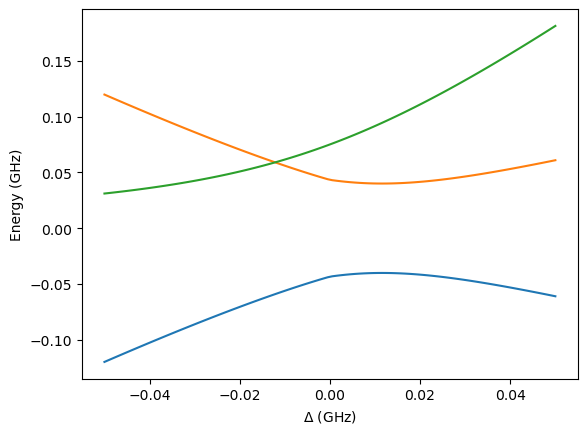

In [115]:
delta_sweep = np.linspace(-1 * g_val, 1 * g_val, 100)

energies0_delta_pos_sym = [energy0_delta_pos_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_delta_pos_sym = [energy1_delta_pos_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies2_delta_pos_sym = [energy2_delta_pos_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


plt.plot(delta_sweep, energies0_delta_pos_sym)
plt.plot(delta_sweep, energies1_delta_pos_sym)
plt.plot(delta_sweep, energies2_delta_pos_sym)


plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Energy (GHz)')

plt.show()

#### Third NPAD

### $\Delta < 0$

In [116]:
h2_delta_neg

Matrix([
[sqrt(g**2*s1**2 + Δ2**2)*Abs(Δ2)/Δ2, c1*g*sin(atan(g*s1/Δ2)/2),                                    0],
[          c1*g*sin(atan(g*s1/Δ2)/2),                        δ2,            c1*g*cos(atan(g*s1/Δ2)/2)],
[                                  0, c1*g*cos(atan(g*s1/Δ2)/2), -sqrt(g**2*s1**2 + Δ2**2)*Abs(Δ2)/Δ2]])

In [117]:
h2_delta_neg_delta2_neg = h2_delta_neg.applyfunc(lambda elem: refine(elem, Q.negative(delta2)))
h2_delta_neg_delta2_neg

Matrix([
[-sqrt(g**2*s1**2 + Δ2**2), c1*g*sin(atan(g*s1/Δ2)/2),                         0],
[c1*g*sin(atan(g*s1/Δ2)/2),                        δ2, c1*g*cos(atan(g*s1/Δ2)/2)],
[                        0, c1*g*cos(atan(g*s1/Δ2)/2),  sqrt(g**2*s1**2 + Δ2**2)]])

\begin{align}
&shift3 = \frac{\delta_2 + \sqrt{\Delta_2^2 + g^2s_1^2}}{2} \\
&\Delta_3 = \delta_2 - shift3 \\
&s_2 = \sin\left({\frac{\arctan{(gs_1/\Delta_2)}}{2}}\right) \\
&c_2 = \cos\left({\frac{\arctan{(gs_1/\Delta_2)}}{2}}\right)
\end{align}

$$
\delta_3 = - \sqrt{\Delta_2^2 + g^2s_1^2} - shift3
$$

In [64]:
s2 = sp.Symbol('s2', real=True)
c2 = sp.Symbol('c2', real=True)
delta3 = sp.Symbol('Δ3', real=True)
del3 = sp.Symbol('δ3', real=True)
s2_delta2_sub = (s2, sp.sin(sp.atan(g * s1 / delta2) / 2))
c2_delta2_sub = (c2, sp.cos(sp.atan(g * s1 / delta2) / 2))

s2_delta2_sub_re = (sp.sin(sp.atan(g * s1 / delta2) / 2), s2)
c2_delta2_sub_re = (sp.cos(sp.atan(g * s1 / delta2) / 2), c2)

shift3 = (del2 + sp.sqrt(delta2**2 + g ** 2 * s1 ** 2)) / 2

delta3_delta2_sub = (delta3, del2 - shift3)
delta3_delta2_sub_re = (del2 - shift3, delta3)
del3_delta2_sub = (del3, - sp.sqrt(delta2**2 + g**2*s1**2) - shift3)
del3_delta2_sub_re = (- sp.sqrt(delta2**2 + g**2*s1**2) - shift3, del3)


In [65]:
h2_delta_neg_delta2_neg_shift = h2_delta_neg_delta2_neg - sp.eye(3) * shift3
h2_delta_neg_delta2_neg_shift

Matrix([
[-δ2/2 - 3*sqrt(g**2*s1**2 + Δ2**2)/2,         c1*g*sin(atan(g*s1/Δ2)/2),                                  0],
[           c1*g*sin(atan(g*s1/Δ2)/2), δ2/2 - sqrt(g**2*s1**2 + Δ2**2)/2,          c1*g*cos(atan(g*s1/Δ2)/2)],
[                                   0,         c1*g*cos(atan(g*s1/Δ2)/2), -δ2/2 + sqrt(g**2*s1**2 + Δ2**2)/2]])

In [66]:
h2_delta_neg_delta2_neg_shift_input = h2_delta_neg_delta2_neg_shift.subs([c2_delta2_sub_re, s2_delta2_sub_re, delta3_delta2_sub_re])
h2_delta_neg_delta2_neg_shift_input 

Matrix([
[-δ2/2 - 3*sqrt(g**2*s1**2 + Δ2**2)/2, c1*g*s2,       0],
[                             c1*g*s2,      Δ3, c1*c2*g],
[                                   0, c1*c2*g,     -Δ3]])

In [67]:
h3_delta_neg_delta2_neg = npad_rot_sym(h2_delta_neg_delta2_neg_shift_input , 1, 2)
h3_delta_neg_delta2_neg

Matrix([
[-δ2/2 - 3*sqrt(g**2*s1**2 + Δ2**2)/2,                                                                                                                                                  c1*g*s2*cos(atan(c1*c2*g/Δ3)/2),                                                                                                                                                 -c1*g*s2*sin(atan(c1*c2*g/Δ3)/2)],
[     c1*g*s2*cos(atan(c1*c2*g/Δ3)/2),  (c1*c2*g*sin(atan(c1*c2*g/Δ3)/2) + Δ3*cos(atan(c1*c2*g/Δ3)/2))*cos(atan(c1*c2*g/Δ3)/2) + (c1*c2*g*cos(atan(c1*c2*g/Δ3)/2) - Δ3*sin(atan(c1*c2*g/Δ3)/2))*sin(atan(c1*c2*g/Δ3)/2), -(c1*c2*g*sin(atan(c1*c2*g/Δ3)/2) + Δ3*cos(atan(c1*c2*g/Δ3)/2))*sin(atan(c1*c2*g/Δ3)/2) + (c1*c2*g*cos(atan(c1*c2*g/Δ3)/2) - Δ3*sin(atan(c1*c2*g/Δ3)/2))*cos(atan(c1*c2*g/Δ3)/2)],
[    -c1*g*s2*sin(atan(c1*c2*g/Δ3)/2), (-c1*c2*g*sin(atan(c1*c2*g/Δ3)/2) - Δ3*cos(atan(c1*c2*g/Δ3)/2))*sin(atan(c1*c2*g/Δ3)/2) + (c1*c2*g*cos(atan(c1*c2*g/Δ3)/2) - Δ3*sin(atan(c1*c2*g/Δ3)/2))*cos(ata

In [68]:
h3_delta_neg_delta2_neg = h3_delta_neg_delta2_neg.applyfunc(lambda elem: sp.simplify(elem))
h3_delta_neg_delta2_neg = h3_delta_neg_delta2_neg.applyfunc(lambda elem: sp.simplify(elem))
h3_delta_neg_delta2_neg

Matrix([
[-δ2/2 - 3*sqrt(g**2*s1**2 + Δ2**2)/2,           c1*g*s2*cos(atan(c1*c2*g/Δ3)/2),           -c1*g*s2*sin(atan(c1*c2*g/Δ3)/2)],
[     c1*g*s2*cos(atan(c1*c2*g/Δ3)/2), sqrt(c1**2*c2**2*g**2 + Δ3**2)*Abs(Δ3)/Δ3,                                          0],
[    -c1*g*s2*sin(atan(c1*c2*g/Δ3)/2),                                         0, -sqrt(c1**2*c2**2*g**2 + Δ3**2)*Abs(Δ3)/Δ3]])

In [69]:
energy0_step3_expr = sp.simplify(refine(h3_delta_neg_delta2_neg[0, 0], Q.negative(delta2)))
energy0_step3_expr = energy0_step3_expr.subs([s1_delta_sub, delta2_delta_sub, del2_delta_sub])
energy0_step3_expr

-3*Δ/4 - 3*sqrt(g**2 + Δ**2)/4 - 3*sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2

In [70]:
energy1_step3_expr = sp.simplify(refine(h3_delta_neg_delta2_neg[1, 1], Q.negative(delta3)))
energy1_step3_expr = energy1_step3_expr.subs([c1_delta_sub, c2_delta2_sub, s1_delta_sub, delta2_delta_sub, del2_delta_sub, delta3_delta2_sub])
energy1_step3_expr = energy1_step3_expr.subs([s1_delta_sub, delta2_delta_sub, del2_delta_sub])

energy1_step3_expr

-sqrt(g**2*cos(atan(g/Δ)/2)**2*cos(atan(g*sin(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)

In [71]:
energy2_step3_expr = sp.simplify(refine(h3_delta_neg_delta2_neg[2, 2], Q.negative(delta2)))
energy2_step3_expr = energy2_step3_expr.subs([s1_delta_sub, delta2_delta_sub, del2_delta_sub, c1_delta_sub, c2_delta2_sub, delta3_delta2_sub])
energy2_step3_expr = energy2_step3_expr.subs([s1_delta_sub])

energy2_step3_expr

-sqrt(g**2*cos(atan(g/Δ)/2)**2*cos(atan(g*sin(atan(g/Δ)/2)/Δ2)/2)**2 + (δ2/2 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + Δ2**2)/2)**2)*Abs(δ2/2 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + Δ2**2)/2)/(δ2/2 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + Δ2**2)/2)

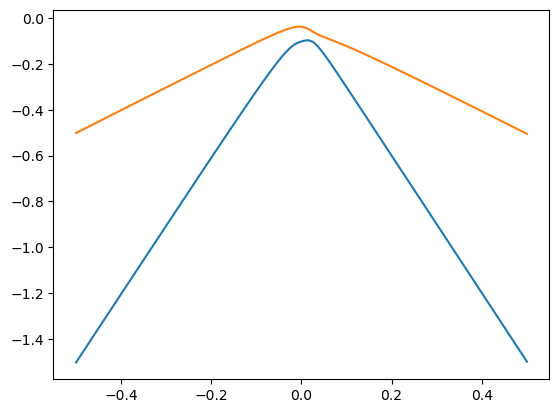

In [72]:

energies0_step3_sym = [energy0_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_step3_sym = [energy1_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies2_step3_sym = [energy2_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


plt.plot(delta_sweep, energies0_step3_sym)
plt.plot(delta_sweep, energies1_step3_sym)
# plt.plot(delta_sweep, energies2_step3_sym)



plt.show()

In [73]:
tls_shift = (energy0_step3_expr + energy1_step3_expr) / 2
energy0_tls_sym = energy0_step3_expr - tls_shift
energy1_tls_sym = energy1_step3_expr - tls_shift
energy0_tls_sym

-3*Δ/8 - 3*sqrt(g**2 + Δ**2)/8 - 3*sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/4 + sqrt(g**2*cos(atan(g/Δ)/2)**2*cos(atan(g*sin(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)/2

In [74]:
energy1_tls_sym

3*Δ/8 + 3*sqrt(g**2 + Δ**2)/8 + 3*sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/4 - sqrt(g**2*cos(atan(g/Δ)/2)**2*cos(atan(g*sin(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)/2

In [75]:
energies0_tls_array = [energy0_tls_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_tls_array = [energy1_tls_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]

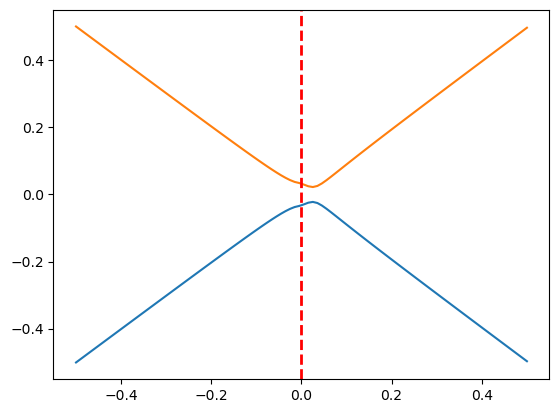

In [76]:

delta_shift_sweep = delta_sweep - 0.25 * a_val

plt.plot(delta_sweep, energies0_tls_array)
plt.plot(delta_sweep, energies1_tls_array)

# plt.plot(delta_shift_sweep, energies0_tls_array)
# plt.plot(delta_shift_sweep, energies1_tls_array)

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.show()

### $\Delta > 0$

In [77]:
h2_delta_pos

Matrix([
[                       δ2,           g*s1*sin(atan(c1*g/Δ2)/2),            g*s1*cos(atan(c1*g/Δ2)/2)],
[g*s1*sin(atan(c1*g/Δ2)/2), sqrt(c1**2*g**2 + Δ2**2)*Abs(Δ2)/Δ2,                                    0],
[g*s1*cos(atan(c1*g/Δ2)/2),                                   0, -sqrt(c1**2*g**2 + Δ2**2)*Abs(Δ2)/Δ2]])

In [78]:
h2_delta_pos_delta2_neg = h2_delta_pos.applyfunc(lambda elem: refine(elem, Q.negative(delta2)))
h2_delta_pos_delta2_neg

Matrix([
[                       δ2, g*s1*sin(atan(c1*g/Δ2)/2), g*s1*cos(atan(c1*g/Δ2)/2)],
[g*s1*sin(atan(c1*g/Δ2)/2), -sqrt(c1**2*g**2 + Δ2**2),                         0],
[g*s1*cos(atan(c1*g/Δ2)/2),                         0,  sqrt(c1**2*g**2 + Δ2**2)]])

\begin{align}
&shift4 = \frac{\delta_2 + \sqrt{\Delta_2^2 + g^2c_1^2}}{2} \\
&\Delta_4 = \delta_2 - shift4 \\
&s_3 = \sin\left({\frac{\arctan{(gc_1/\Delta_2)}}{2}}\right) \\
&c_3 = \cos\left({\frac{\arctan{(gc_1/\Delta_2)}}{2}}\right)
\end{align}

$$
\delta_4 = - \sqrt{\Delta_2^2 + g^2c_1^2} - shift4
$$

In [84]:
s2 = sp.Symbol('s2', real=True)
c2 = sp.Symbol('c2', real=True)
delta3 = sp.Symbol('Δ3', real=True)
del4 = sp.Symbol('δ4', real=True)
s2_delta2_sub = (s2, sp.sin(sp.atan(g * c1 / delta2) / 2))
c2_delta2_sub = (c2, sp.cos(sp.atan(g * c1 / delta2) / 2))

s2_delta2_sub_re = s2_delta2_sub[::-1]
c2_delta2_sub_re = c2_delta2_sub[::-1]

shift4 = (del2 + sp.sqrt(delta2**2 + g ** 2 * c1 ** 2)) / 2

delta3_delta2_sub = (delta3, del2 - shift4)
delta3_delta2_sub_re = delta3_delta2_sub[::-1]
del3_delta2_sub = (del4, - sp.sqrt(delta2**2 + g**2*c1**2) - shift4)
del3_delta2_sub_re = del3_delta2_sub[::-1]

In [85]:
h2_delta_pos_delta2_neg_shift = h2_delta_pos_delta2_neg - sp.eye(3) * shift4
h2_delta_pos_delta2_neg_shift

Matrix([
[δ2/2 - sqrt(c1**2*g**2 + Δ2**2)/2,            g*s1*sin(atan(c1*g/Δ2)/2),          g*s1*cos(atan(c1*g/Δ2)/2)],
[        g*s1*sin(atan(c1*g/Δ2)/2), -δ2/2 - 3*sqrt(c1**2*g**2 + Δ2**2)/2,                                  0],
[        g*s1*cos(atan(c1*g/Δ2)/2),                                    0, -δ2/2 + sqrt(c1**2*g**2 + Δ2**2)/2]])

In [86]:
h2_delta_pos_delta2_neg_shift_input = h2_delta_pos_delta2_neg_shift.subs([c2_delta2_sub_re, s2_delta2_sub_re, delta3_delta2_sub_re])
h2_delta_pos_delta2_neg_shift_input 

Matrix([
[     Δ3,                              g*s1*s2, c2*g*s1],
[g*s1*s2, -δ2/2 - 3*sqrt(c1**2*g**2 + Δ2**2)/2,       0],
[c2*g*s1,                                    0,     -Δ3]])

In [87]:
h3_delta_pos_delta2_neg = npad_rot_sym(h2_delta_pos_delta2_neg_shift_input, 0, 2)
h3_delta_pos_delta2_neg

Matrix([
[ (c2*g*s1*sin(atan(c2*g*s1/Δ3)/2) + Δ3*cos(atan(c2*g*s1/Δ3)/2))*cos(atan(c2*g*s1/Δ3)/2) + (c2*g*s1*cos(atan(c2*g*s1/Δ3)/2) - Δ3*sin(atan(c2*g*s1/Δ3)/2))*sin(atan(c2*g*s1/Δ3)/2),      g*s1*s2*cos(atan(c2*g*s1/Δ3)/2), -(c2*g*s1*sin(atan(c2*g*s1/Δ3)/2) + Δ3*cos(atan(c2*g*s1/Δ3)/2))*sin(atan(c2*g*s1/Δ3)/2) + (c2*g*s1*cos(atan(c2*g*s1/Δ3)/2) - Δ3*sin(atan(c2*g*s1/Δ3)/2))*cos(atan(c2*g*s1/Δ3)/2)],
[                                                                                                                                                 g*s1*s2*cos(atan(c2*g*s1/Δ3)/2), -δ2/2 - 3*sqrt(c1**2*g**2 + Δ2**2)/2,                                                                                                                                                 -g*s1*s2*sin(atan(c2*g*s1/Δ3)/2)],
[(-c2*g*s1*sin(atan(c2*g*s1/Δ3)/2) - Δ3*cos(atan(c2*g*s1/Δ3)/2))*sin(atan(c2*g*s1/Δ3)/2) + (c2*g*s1*cos(atan(c2*g*s1/Δ3)/2) - Δ3*sin(atan(c2*g*s1/Δ3)/2))*cos(atan(c2*g*s1/Δ3)/2),     -g*s1*s2*sin(ata

In [89]:
h3_delta_pos_delta2_neg = h3_delta_pos_delta2_neg.applyfunc(lambda elem: sp.simplify(elem))
h3_delta_pos_delta2_neg = h3_delta_pos_delta2_neg.applyfunc(lambda elem: sp.simplify(elem))
h3_delta_pos_delta2_neg

Matrix([
[sqrt(c2**2*g**2*s1**2 + Δ3**2)*Abs(Δ3)/Δ3,      g*s1*s2*cos(atan(c2*g*s1/Δ3)/2),                                          0],
[          g*s1*s2*cos(atan(c2*g*s1/Δ3)/2), -δ2/2 - 3*sqrt(c1**2*g**2 + Δ2**2)/2,           -g*s1*s2*sin(atan(c2*g*s1/Δ3)/2)],
[                                        0,     -g*s1*s2*sin(atan(c2*g*s1/Δ3)/2), -sqrt(c2**2*g**2*s1**2 + Δ3**2)*Abs(Δ3)/Δ3]])

In [90]:
energy0_delta_pos_delta2_neg_step3_expr = sp.simplify(refine(h3_delta_pos_delta2_neg[1, 1], Q.negative(delta2)))
energy0_delta_pos_delta2_neg_step3_expr = energy0_delta_pos_delta2_neg_step3_expr.subs([s1_delta_sub, c1_delta_sub, delta2_delta_sub, del2_delta_sub])
energy0_delta_pos_delta2_neg_step3_expr

-3*Δ/4 - 3*sqrt(g**2 + Δ**2)/4 - 3*sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2

In [92]:
energy1_delta_pos_delta2_neg_step3_expr = sp.simplify(refine(h3_delta_pos_delta2_neg[2, 2], Q.negative(delta2)))
energy1_delta_pos_delta2_neg_step3_expr = sp.simplify(refine(h3_delta_pos_delta2_neg[2, 2], Q.negative(delta3)))

energy1_delta_pos_delta2_neg_step3_expr = energy1_delta_pos_delta2_neg_step3_expr.subs([s1_delta_sub, c1_delta_sub, c2_delta2_sub, delta2_delta_sub, del2_delta_sub, delta3_delta2_sub])
energy1_delta_pos_delta2_neg_step3_expr = energy1_delta_pos_delta2_neg_step3_expr.subs([s1_delta_sub, c1_delta_sub, delta2_delta_sub, del2_delta_sub, delta3_delta2_sub])

energy1_delta_pos_delta2_neg_step3_expr

sqrt(g**2*sin(atan(g/Δ)/2)**2*cos(atan(g*cos(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)

In [96]:
energy2_delta_pos_delta2_neg_step3_expr = sp.simplify(refine(h3_delta_pos_delta2_neg[0, 0], Q.negative(delta2)))
energy2_delta_pos_delta2_neg_step3_expr = sp.simplify(refine(h3_delta_pos_delta2_neg[0, 0], Q.negative(delta3)))

energy2_delta_pos_delta2_neg_step3_expr = energy2_delta_pos_delta2_neg_step3_expr.subs([s1_delta_sub, c2_delta2_sub, delta2_delta_sub, del2_delta_sub, delta3_delta2_sub])
energy2_delta_pos_delta2_neg_step3_expr = energy2_delta_pos_delta2_neg_step3_expr.subs([s1_delta_sub, c2_delta2_sub, delta2_delta_sub, del2_delta_sub, delta3_delta2_sub])
energy2_delta_pos_delta2_neg_step3_expr = energy2_delta_pos_delta2_neg_step3_expr.subs([c1_delta_sub])


energy2_delta_pos_delta2_neg_step3_expr

-sqrt(g**2*sin(atan(g/Δ)/2)**2*cos(atan(g*cos(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)

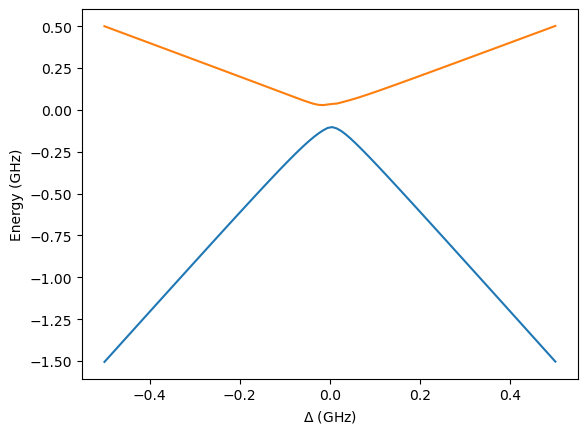

In [102]:
energies0_delta_pos_delta2_neg_step3_sym = [energy0_delta_pos_delta2_neg_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_delta_pos_delta2_neg_step3_sym = [energy1_delta_pos_delta2_neg_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies2_delta_pos_delta2_neg_step3_sym = [energy2_delta_pos_delta2_neg_step3_expr.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]


plt.plot(delta_sweep, energies0_delta_pos_delta2_neg_step3_sym)
plt.plot(delta_sweep, energies1_delta_pos_delta2_neg_step3_sym)
# plt.plot(delta_sweep, energies2_delta_pos_delta2_neg_step3_sym)

plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Energy (GHz)')
plt.show()

In [103]:
tls2_shift = (energy0_delta_pos_delta2_neg_step3_expr + energy1_delta_pos_delta2_neg_step3_expr) / 2
energy0_tls2_sym = energy0_delta_pos_delta2_neg_step3_expr - tls2_shift
energy1_tls2_sym = energy1_delta_pos_delta2_neg_step3_expr - tls2_shift
energy0_tls2_sym

-3*Δ/8 - 3*sqrt(g**2 + Δ**2)/8 - 3*sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/4 - sqrt(g**2*sin(atan(g/Δ)/2)**2*cos(atan(g*cos(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)/2

In [104]:
energy1_tls2_sym


3*Δ/8 + 3*sqrt(g**2 + Δ**2)/8 + 3*sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/4 + sqrt(g**2*sin(atan(g/Δ)/2)**2*cos(atan(g*cos(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)/2

In [105]:
energies0_tls2_array = [energy0_tls2_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]
energies1_tls2_array = [energy1_tls2_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta_sweep]

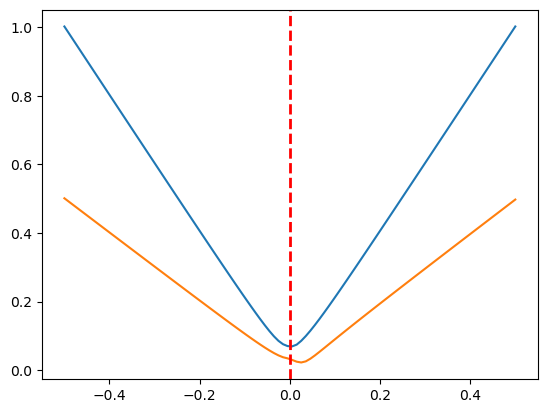

In [106]:
delta_shift_sweep = delta_sweep - 0.25 * a_val

# plt.plot(delta_sweep, energies0_tls2_array)
plt.plot(delta_sweep, energies1_tls2_array)

# plt.plot(delta_sweep, energies0_tls_array)
plt.plot(delta_sweep, energies1_tls_array)

# plt.plot(delta_shift_sweep, energies0_tls_array)
# plt.plot(delta_shift_sweep, energies1_tls_array)

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.show()

### Wrapping up

For $\Delta<0$:


In [92]:
energy0_tls_sym

-3*Δ/8 - 3*sqrt(g**2 + Δ**2)/8 - 3*sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/4 + sqrt(g**2*cos(atan(g/Δ)/2)**2*cos(atan(g*sin(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*sin(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)/2

In [93]:
terms = energy0_tls_sym.as_ordered_terms()
print(terms[1].limit(delta, 0))
print(terms[2].limit(delta, 0))
print(terms[3].limit(delta, 0))


-3*g/8
AccumBounds(-3*sqrt(3)*g/8, -3*g/8)
sqrt(AccumBounds(g**2*AccumBounds(sqrt(3)/12 + 1/4, 1), AccumBounds(sqrt(3)*g**2/12 + g**2/2, 5*g**2/4)))/2


In [94]:
terms[2].limit(delta, 0)

AccumBounds(-3*sqrt(3)*g/8, -3*g/8)

In [95]:
x = sp.Symbol('x', real=True)

# 定义一个带有不确定性的表达式
expr = sp.sin(sp.atan(1/x) / 2) ** 2

# 计算当 x -> 1 时的极限
result = sp.limit(expr, x, 0, dir='-')
print(result)

AccumBounds(0, 1/2)


In [96]:
print(terms[2].limit(delta, 0, dir='+'))

AccumBounds(-3*sqrt(3)*g/8, -3*g/8)


In [97]:
terms[3].limit(delta, 0)

sqrt(AccumBounds(g**2*AccumBounds(sqrt(3)/12 + 1/4, 1), AccumBounds(sqrt(3)*g**2/12 + g**2/2, 5*g**2/4)))/2

In [98]:
limit_expr = sp.limit(energy0_tls_sym, delta, 0, dir='-')  
     
limit_expr

-3*g/8 + AccumBounds(-3*sqrt(3)*g/8, -3*g/8) + sqrt(AccumBounds(g**2*AccumBounds(sqrt(3)/12 + 1/4, 1), AccumBounds(sqrt(3)*g**2/12 + g**2/2, 5*g**2/4)))/2

In [99]:
(-3/8) + (-3*np.sqrt(3)/8) + 0.5 * np.sqrt((((3 + np.sqrt(3)) / 12) + ((3 - np.sqrt(3))/4) ** 2))

-0.6728023648424801

In [100]:
(-3/8) + (-3*np.sqrt(3)/8) + 0.5 * np.sqrt((((3 + np.sqrt(3)) / 12)))


-0.7105375377385519

For $\Delta>0$:

In [107]:
energy1_tls2_sym


3*Δ/8 + 3*sqrt(g**2 + Δ**2)/8 + 3*sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/4 + sqrt(g**2*sin(atan(g/Δ)/2)**2*cos(atan(g*cos(atan(g/Δ)/2)/(3*Δ/2 - sqrt(g**2 + Δ**2)/2))/2)**2 + (3*Δ/4 + 3*sqrt(g**2 + Δ**2)/4 - sqrt(g**2*cos(atan(g/Δ)/2)**2 + (3*Δ/2 - sqrt(g**2 + Δ**2)/2)**2)/2)**2)/2

In [108]:
energy1_tls2_sym.limit(delta, 0)

3*g/8 + AccumBounds(3*sqrt(3)*g/8, 3*sqrt(5)*g/8) + sqrt(AccumBounds(g**2*AccumBounds(0, sqrt(3)/12 + 1/4), g**2*AccumBounds(3/4, sqrt(3)/12 + 1) - 3*sqrt(3)*g**2/8))/2

In [109]:
effective_factor = (3/8) + (3 * np.sqrt(3) / 8) - np.sqrt(0.5 * np.cos(np.arctan(np.cos(np.sqrt(2)/4) / (-0.5)) / 2) ** 2 + (3/4 - np.sqrt(0.5 + 0.25) / 2) ** 2) / 2
effective_factor

0.6824427846947151

In [104]:
x = sp.Symbol('x', real=True)
x1 = sp.Symbol('x1', real=True)


In [105]:
e1_x = energy1_tls_sym.subs([(delta, x), (g, 1)])

In [106]:
e1_x

3*x/8 + 3*sqrt(x**2 + 1)/8 + 3*sqrt((3*x/2 - sqrt(x**2 + 1)/2)**2 + sin(atan(1/x)/2)**2)/4 - sqrt((3*x/4 + 3*sqrt(x**2 + 1)/4 - sqrt((3*x/2 - sqrt(x**2 + 1)/2)**2 + sin(atan(1/x)/2)**2)/2)**2 + cos(atan(1/x)/2)**2*cos(atan(sin(atan(1/x)/2)/(3*x/2 - sqrt(x**2 + 1)/2))/2)**2)/2

In [107]:
e1_sim = sp.simplify(e1_x).subs(sp.sqrt(1 + x ** 2), 1 + x ** 2 / 2)

In [108]:
e1_sim

3*x**2/16 + 3*x/8 - sqrt(4*(1 + 1/sqrt(1 + x**(-2)))*(1 + 1/sqrt(1 + 2/(-x**2/2 + 3*x - 1)**2 - 2/(sqrt(1 + x**(-2))*(-x**2/2 + 3*x - 1)**2))) + (3*x**2/2 + 3*x - sqrt((-x**2/2 + 3*x - 1)**2 + 2 - 2/sqrt(1 + x**(-2))) + 3)**2)/8 + 3*sqrt((-x**2/2 + 3*x - 1)**2 + 2 - 2/sqrt(1 + x**(-2)))/8 + 3/8

## Numerical NPAD validation

In [118]:
g_val = 50e-3
a_val = -0.e-3
# delta_qc_sweep = np.linspace(-20 * g_val, 20 * g_val, 100)
delta1_sweep = np.linspace(-1. * g_val, 1. * g_val, 100)

In [119]:
def ham_3ls_delta1(delta1, g, a):
    h_mat = np.array([
    [delta1, g, 0.],
    [g, -delta1, g], 
    [0, g, a - 3*delta1]
    ], dtype=complex)
    return h_mat

[]

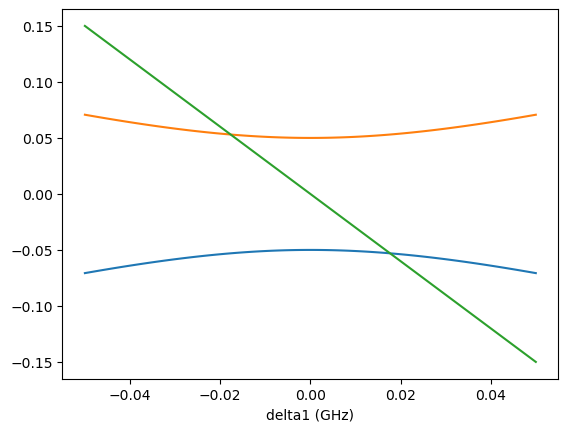

In [120]:
energies_3ls_step1_list = []

h1_list = [npad_rot(ham_3ls_delta1(d1, g_val, a_val), 0, 1) for d1 in delta1_sweep]

for h in h1_list:
    energies = Qobj(h).diag()
    energies_3ls_step1_list.append(energies)
energies_3ls_step1_mat = np.array(energies_3ls_step1_list).T

plt.plot(delta1_sweep, energies_3ls_step1_mat[0])
plt.plot(delta1_sweep, energies_3ls_step1_mat[1])
plt.plot(delta1_sweep, energies_3ls_step1_mat[2])

plt.xlabel('delta1 (GHz)')
plt.plot()

In [121]:
h2_list = []
for h1 in h1_list:
    shift = 0.5 * (h1[0, 0] + h1[2, 2])
    h2_list.append(npad_rot(h1 - shift * np.eye(3), 0, 2))

[]

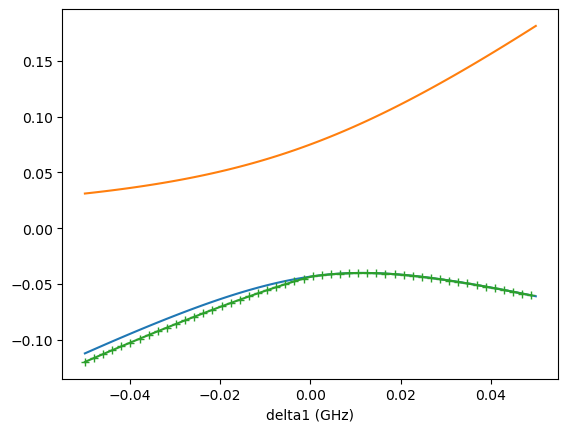

In [122]:
step = 2
energies_3ls_step2_list = []

delta2_sweep = 0.5 * (3 * delta1_sweep - np.sqrt(delta1_sweep ** 2 + g_val ** 2) - a_val)

for h in h2_list:
    energies = Qobj(h).diag()
    energies_3ls_step2_list.append(energies)
energies_3ls_step2_mat = np.array(energies_3ls_step2_list).T

plt.plot(delta1_sweep, energies_3ls_step2_mat[0])
plt.plot(delta1_sweep, energies_3ls_step2_mat[1])
# plt.plot(delta1_sweep, energies_3ls_step2_mat[2])



# plt.plot(delta_sweep[::step], energies0_delta_neg_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies1_delta_neg_sym[::step], '.-')
# plt.plot(delta_sweep[::step], energies2_delta_neg_sym[::step], '.-')
plt.plot(delta1_sweep[::step], energies0_delta_pos_sym[::step], '+-')

plt.xlabel('delta1 (GHz)')
plt.plot()

[]

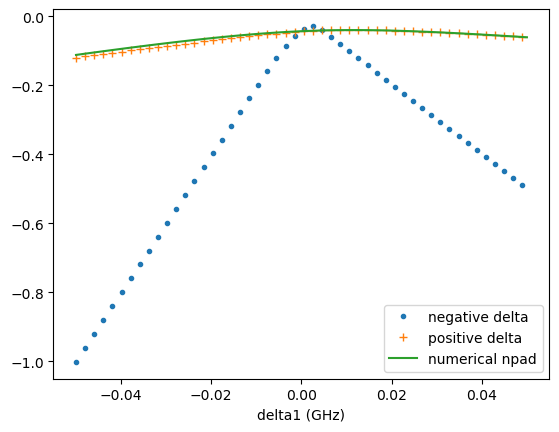

In [124]:
plt.plot(delta_sweep[::step], energies0_delta_neg_sym[::step], '.', label='negative delta')
plt.plot(delta_sweep[::step], energies0_delta_pos_sym[::step], '+', label='positive delta')
plt.plot(delta1_sweep, energies_3ls_step2_mat[0], label='numerical npad')


plt.legend()
plt.xlabel('delta1 (GHz)')
plt.plot()

In [125]:
h3_list = []
for h2 in h2_list:
    shift = 0.5 * (h2[1, 1] + h2[2, 2])
    # shift = 0.
    h3_list.append(npad_rot(h2 - shift * np.eye(3), 1, 2))

[]

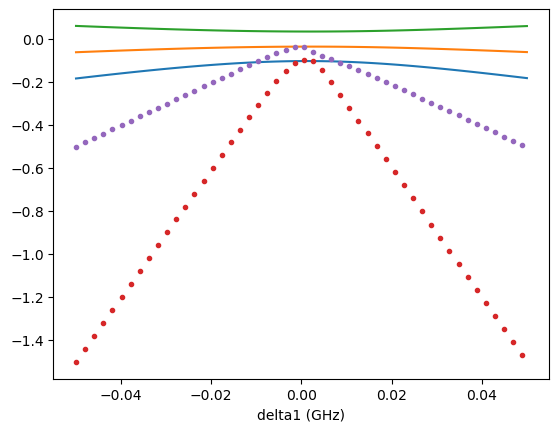

In [126]:
step = 2
energies_3ls_step3_list = []


for h in h3_list:
    energies = Qobj(h).diag()
    energies_3ls_step3_list.append(energies)
energies_3ls_step3_mat = np.array(energies_3ls_step3_list).T

plt.plot(delta1_sweep, energies_3ls_step3_mat[0])
plt.plot(delta1_sweep, energies_3ls_step3_mat[1])
plt.plot(delta1_sweep, energies_3ls_step3_mat[2])


plt.plot(delta_sweep[::step], energies0_step3_sym[::step], '.')
plt.plot(delta_sweep[::step], energies1_step3_sym[::step], '.')

plt.xlabel('delta1 (GHz)')
plt.plot()

In [127]:
factor = 0.6728

def fit_tls(x, g, a, x0):
    return a * np.sqrt((x-x0) ** 2 + g ** 2)

def fit_tls_simple(x, g):
    return -np.sqrt(x ** 2 +  g ** 2)

shift01 = 0.5 * (energies_3ls_step3_mat[0] + energies_3ls_step3_mat[1])
is_shift = 1.

energies0_tls_mat_array=energies_3ls_step3_mat[0] - is_shift * shift01
energies1_tls_mat_array=energies_3ls_step3_mat[1] - is_shift * shift01

xdata = delta1_sweep
ydata = energies0_tls_mat_array
para_tls, pcov = curve_fit(fit_tls, xdata, ydata, method='trf')


In [128]:
print('effective g:', para_tls[0])
print('real g:', g_val)
print('ratio:', para_tls[0] / g_val)

effective g: -0.033198523202031656
real g: 0.05
ratio: -0.6639704640406331


In [129]:
energies0_tls_array = [energy0_tls_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta1_sweep]
energies1_tls_array = [energy1_tls_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta1_sweep]

energies0_tls2_array = [energy0_tls2_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta1_sweep]
energies1_tls2_array = [energy1_tls2_sym.subs({g: g_val, delta: d, a: a_val}) for d in delta1_sweep]

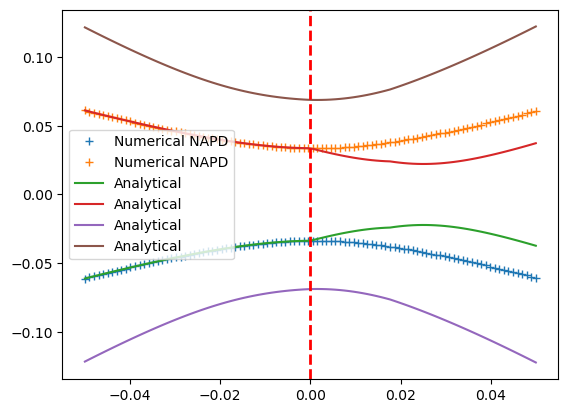

In [130]:

plt.plot(delta1_sweep[::1], energies0_tls_mat_array[::1], '+', label='Numerical NAPD')
plt.plot(delta1_sweep[::1], energies1_tls_mat_array[::1], '+', label='Numerical NAPD')

# plt.plot(delta1_sweep, fit_tls(xdata, para_tls[0], para_tls[1]), '-', label='tls fit')
# plt.plot(delta1_sweep, -fit_tls(xdata, para_tls[0], para_tls[1]), '-', label='tls fit')

# plt.plot(delta1_sweep, fit_tls_simple(xdata, para_tls[0]), '-', label='tls fit')
# plt.plot(delta1_sweep, -fit_tls_simple(xdata, para_tls[0]), '-', label='tls fit')


plt.plot(delta1_sweep[::1], energies0_tls_array[::1], '-', label='Analytical')
plt.plot(delta1_sweep[::1], energies1_tls_array[::1], '-', label='Analytical')

plt.plot(delta1_sweep[::1], energies0_tls2_array[::1], '-', label='Analytical')
plt.plot(delta1_sweep[::1], energies1_tls2_array[::1], '-', label='Analytical')

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.legend()
plt.show()



In [131]:
xdata = delta1_sweep
ydata = energies0_tls_mat_array
para_tls_eigen, pcov = curve_fit(fit_tls_simple, xdata, ydata, method='trf')

[]

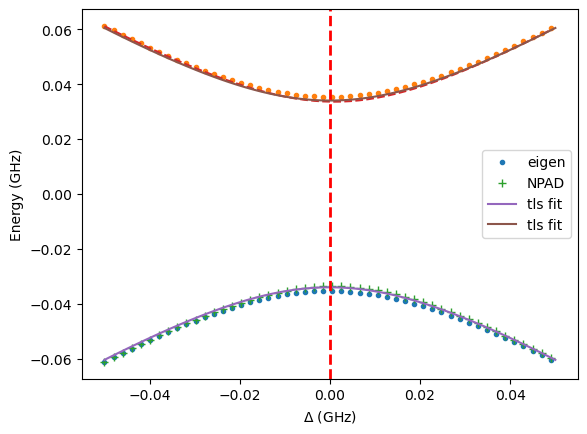

In [132]:
# Compare to real eigenvalues
eigen_3ls_energies = []
for d1 in delta1_sweep:
    _h = ham_3ls_delta1(d1, g_val, a_val)
    h_qobj = Qobj(_h)
    energies = h_qobj.eigenenergies()
    eigen_3ls_energies.append(energies)
eigen_3ls_energies_mat = np.array(eigen_3ls_energies).T

eigen_shift = 0.5 * (eigen_3ls_energies_mat[0] +  eigen_3ls_energies_mat[1])
eigen_val0 = eigen_3ls_energies_mat[0] - eigen_shift
eigen_val1 = eigen_3ls_energies_mat[1] - eigen_shift

eigen_step = 2

plt.plot(delta1_sweep[::eigen_step], eigen_val0[::eigen_step], '.', label='eigen')
plt.plot(delta1_sweep[::eigen_step], eigen_val1[::eigen_step], '.')

plt.plot(delta1_sweep[::2], energies0_tls_mat_array[::2], '+', label='NPAD')
plt.plot(delta1_sweep[::2], energies1_tls_mat_array[::2], '--')


plt.plot(delta1_sweep, fit_tls_simple(xdata, para_tls_eigen[0]), '-', label='tls fit')
plt.plot(delta1_sweep, -fit_tls_simple(xdata, para_tls_eigen[0]), '-', label='tls fit')

# plt.plot(delta1_sweep, fit_tls_simple(xdata, para_tls[0]), '-', label='tls fit')
# plt.plot(delta1_sweep, -fit_tls_simple(xdata, para_tls[0]), '-', label='tls fit')

# plt.plot(delta1_sweep[::1], energies0_tls_array[::1], '-', label='Analytical')
# plt.plot(delta1_sweep[::1], energies1_tls_array[::1], '-', label='Analytical')


plt.axvline(x=0., color='r', linestyle='--', linewidth=2)

plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Energy (GHz)')

plt.legend()
plt.plot()

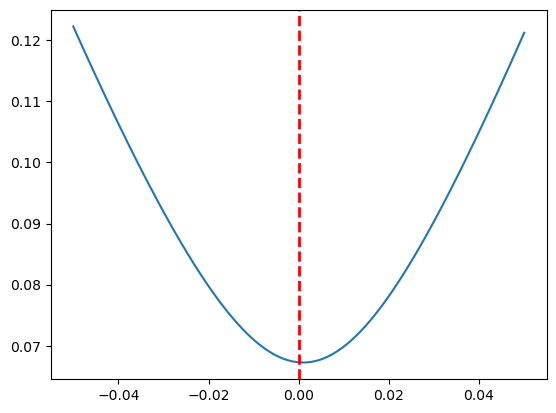

In [133]:
# diff2 = energies_3ls_step3_mat[1] - energies_3ls_step3_mat[0]
# diff_sym = np.array(energies1_tls_array) - np.array(energies0_tls_array)
diff_npad = energies1_tls_mat_array - energies0_tls_mat_array
# plt.plot(delta1_sweep, energies0_tls_mat_array)
# plt.plot(delta1_sweep, energies1_tls_mat_array)
plt.plot(delta1_sweep, diff_npad)

# plt.plot(delta1_sweep, diff_sym)

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)


plt.show()

In [172]:
g_val2 = 47e-3
def plot_eigen(x, h_list, plot_step=1, marker='.'):
    eigen_3ls_energies = []
    for _h in h_list:
        h_qobj = Qobj(_h)
        energies = h_qobj.eigenenergies()
        eigen_3ls_energies.append(energies)
    eigen_3ls_energies_mat = np.array(eigen_3ls_energies).T
    plt.plot(x[::plot_step], eigen_3ls_energies_mat[0][::plot_step], marker)
    plt.plot(x[::plot_step], eigen_3ls_energies_mat[1][::plot_step], marker)
    return eigen_3ls_energies_mat

def thrls_ham(delta, g):
    mat = np.array([
        [delta, np.sqrt(2) * g, 0.],
        [np.sqrt(2) * g, -delta, np.sqrt(2) * g],
        [0., np.sqrt(2) * g, -3 * delta]
    ])
    return mat

# def effective_tls_ham(delta, g):
#     mat = np.array([
#         [delta, 0.68244 * np.sqrt(2) * g],
#         [0.68244 * np.sqrt(2) * g, -delta]
#     ])
#     return mat

def effective_tls_ham(delta, g):
    mat = np.array([
        [delta,  g],
        [g, -delta]
    ])
    return mat
    

In [173]:
delta_sweep = np.linspace(-5 * g_val2, 5 * g_val2, 100)
h_3ls_list = [thrls_ham(d, g_val2) for d in delta_sweep]
h_tls_list = [effective_tls_ham(d, g_val2) for d in delta_sweep]


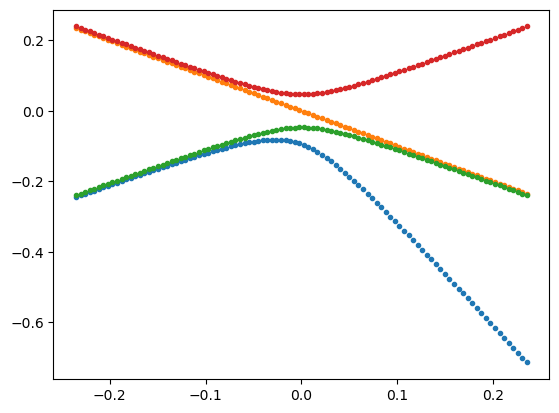

In [174]:
eigen_mat_3ls = plot_eigen(delta_sweep, h_3ls_list)
eigen_mat_tls = plot_eigen(delta_sweep, h_tls_list)

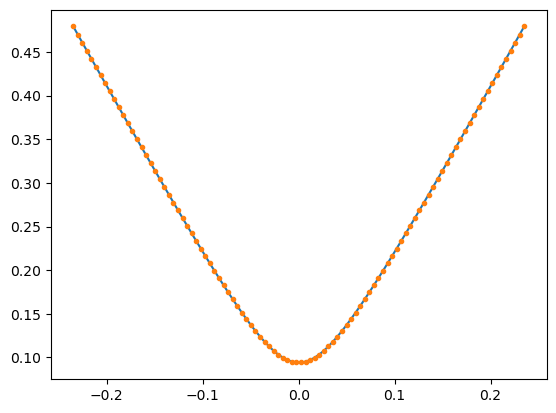

In [175]:
diff1 = eigen_mat_3ls[1] - eigen_mat_3ls[0]
diff2 = eigen_mat_tls[1] - eigen_mat_tls[0]
plt.plot(delta_sweep, diff1)
plt.plot(delta_sweep, diff2, '.')


plt.show()

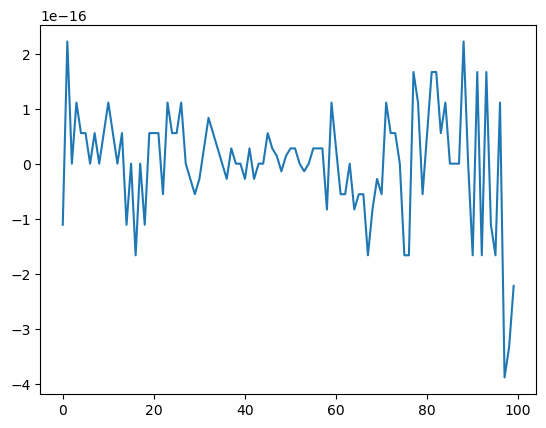

In [171]:
plt.plot(diff1 - diff2)
plt.show()

# Symbol NPAD for anharm is not 0

The original Hamiltonian:

\begin{align}
H_0 = \begin{pmatrix}
2\omega_q + \alpha & g & 0 \\ g & \omega_q + \omega_c & g \\ 0 & g & 2\omega_c
\end{pmatrix}
\end{align}

In [124]:
wq = sp.Symbol('wq', positive=True, real=True, dtype=float)
wc = sp.Symbol('wc', positive=True, real=True, dtype=float)
g = sp.Symbol('g', positive=True, real=True, dtype=float)
a = sp.Symbol('α', positive=False, real=True, dtype=float)
b = sp.Symbol('β', positive=False, real=True, dtype=float)
delta = sp.Symbol('Δ', real=True, dtype=float)
gamma = sp.Symbol('γ', real=True, positive=False, dtype=float)


# h0 = sp.Matrix([
# [delta, g],
# [g,  -delta]])


h0 = sp.Matrix([
[delta,      g,            0],
[g,       -delta,            g],
[0,            g,    -3*delta]])


h0

Matrix([
[Δ,  g,    0],
[g, -Δ,    g],
[0,  g, -3*Δ]])

[]

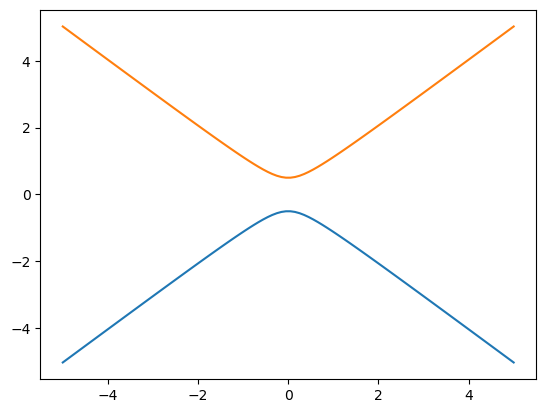

In [125]:
g = 50e-2
detuning_sweep = np.linspace(-5, 5, 100)
energies_list_tls = []
for detune in detuning_sweep:
    h = ham_tls(detune, g)
    h_npad = npad_rot(h, 0, 1)
    energies = Qobj(h_npad).diag()
    energies_list_tls.append(energies)
energies_mat_tls = np.array(energies_list_tls).T

plt.plot(detuning_sweep, energies_mat_tls[0])
plt.plot(detuning_sweep, energies_mat_tls[1])

plt.plot()

In [126]:
g = 50e-3
# g=0.
freq_q = 4.5
anharm_q = -130e-3
anharm_c = -60e-3
freq_c_sweep = np.linspace(5.0, 4.0, 100)

In [127]:
freq_c_sweep

array([5.        , 4.98989899, 4.97979798, 4.96969697, 4.95959596,
       4.94949495, 4.93939394, 4.92929293, 4.91919192, 4.90909091,
       4.8989899 , 4.88888889, 4.87878788, 4.86868687, 4.85858586,
       4.84848485, 4.83838384, 4.82828283, 4.81818182, 4.80808081,
       4.7979798 , 4.78787879, 4.77777778, 4.76767677, 4.75757576,
       4.74747475, 4.73737374, 4.72727273, 4.71717172, 4.70707071,
       4.6969697 , 4.68686869, 4.67676768, 4.66666667, 4.65656566,
       4.64646465, 4.63636364, 4.62626263, 4.61616162, 4.60606061,
       4.5959596 , 4.58585859, 4.57575758, 4.56565657, 4.55555556,
       4.54545455, 4.53535354, 4.52525253, 4.51515152, 4.50505051,
       4.49494949, 4.48484848, 4.47474747, 4.46464646, 4.45454545,
       4.44444444, 4.43434343, 4.42424242, 4.41414141, 4.4040404 ,
       4.39393939, 4.38383838, 4.37373737, 4.36363636, 4.35353535,
       4.34343434, 4.33333333, 4.32323232, 4.31313131, 4.3030303 ,
       4.29292929, 4.28282828, 4.27272727, 4.26262626, 4.25252

In [128]:
energies_list = []
for freq_c in freq_c_sweep:
    h = ham_3ls(freq_q, freq_c, g, anharm_q, anharm_c)
    h = Qobj(h)
    energies = h.eigenenergies()
    energies_list.append(energies)
energies_mat = np.array(energies_list).T

[]

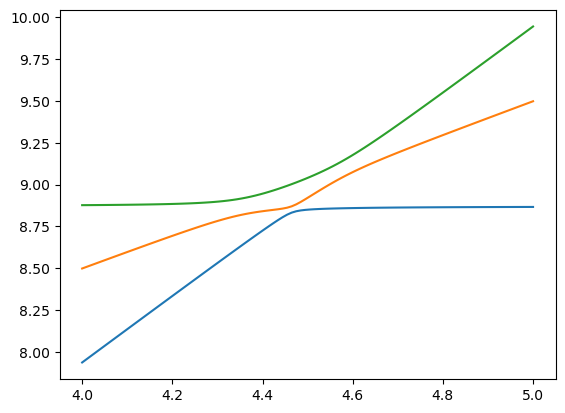

In [129]:
plt.plot(freq_c_sweep, energies_mat[0])
plt.plot(freq_c_sweep, energies_mat[1])
plt.plot(freq_c_sweep, energies_mat[2])

plt.plot()

In [130]:
print(2 * freq_q + anharm_q)
print(freq_q + freq_c)
print(2 * freq_c_sweep[0] + anharm_c)


8.87
8.5
9.94


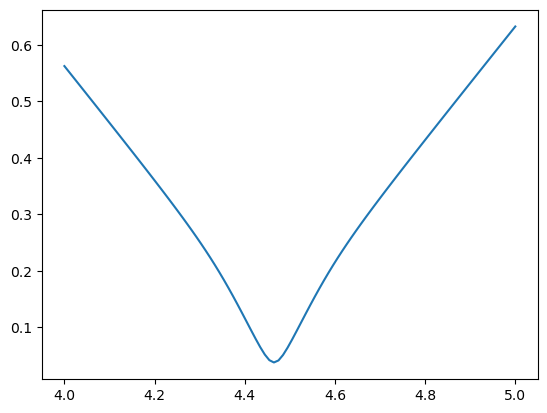

In [131]:
diff = energies_mat[1] - energies_mat[0]
plt.plot(freq_c_sweep, diff)
plt.show()

In [132]:
h1_list = [ham_3ls(freq_q, freq_c, g, anharm_q, anharm_c) for freq_c in freq_c_sweep]
h1_diag = np.array([np.diag(_h) for _h in h1_list]).T

d:\anaconda3\envs\qubit-reset\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda3\envs\qubit-reset\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


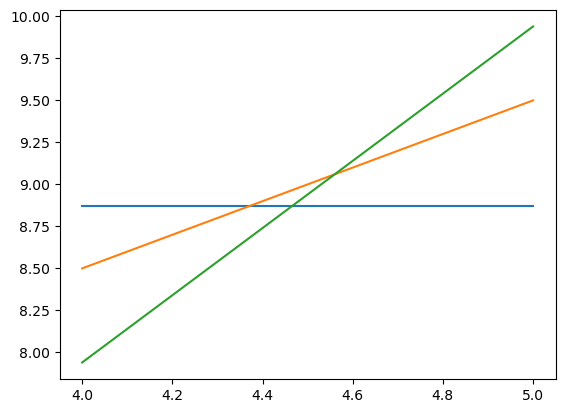

In [133]:
plt.plot(freq_c_sweep, h1_diag[0])
plt.plot(freq_c_sweep, h1_diag[1])
plt.plot(freq_c_sweep, h1_diag[2])

plt.show()

In [134]:
# 0, 1 
h2_list = []
for h1 in h1_list:
    h2_list.append(npad_rot(h1, 0, 1))

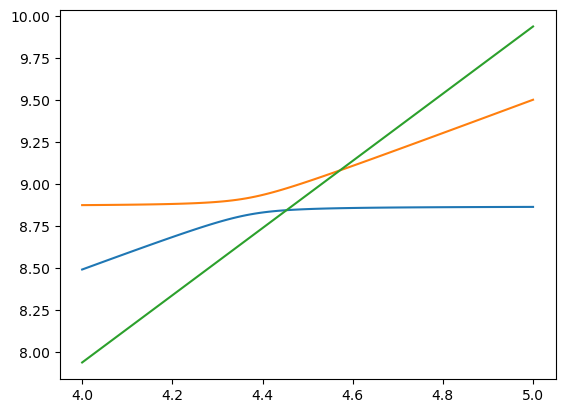

In [135]:
h2_diag = np.array([Qobj(h).diag() for h in h2_list]).T
plt.plot(freq_c_sweep, h2_diag[0])
plt.plot(freq_c_sweep, h2_diag[1])
plt.plot(freq_c_sweep, h2_diag[2])

plt.show()

In [136]:
# 0, 2
h3_list = []
for h2 in h2_list:
    h3_list.append(npad_rot(h2, 0, 2))

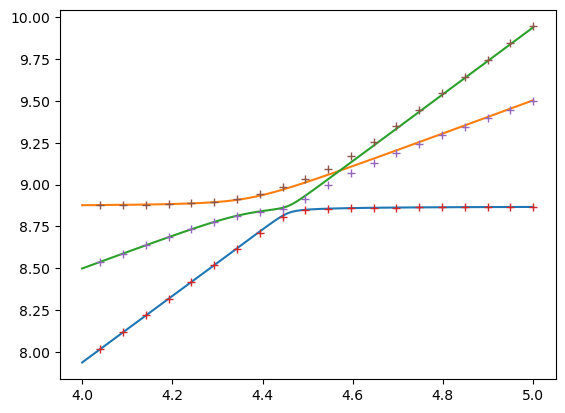

In [137]:
h3_diag = np.array([Qobj(h).diag() for h in h3_list]).T
plt.plot(freq_c_sweep, h3_diag[0])
plt.plot(freq_c_sweep, h3_diag[1])
plt.plot(freq_c_sweep, h3_diag[2])
plt.plot(freq_c_sweep[::5], energies_mat[0][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[1][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[2][::5], '+')

plt.show()

In [138]:
# 1, 2
h4_list = []
for h3 in h3_list:
    h4_list.append(npad_rot(h3, 1, 2))

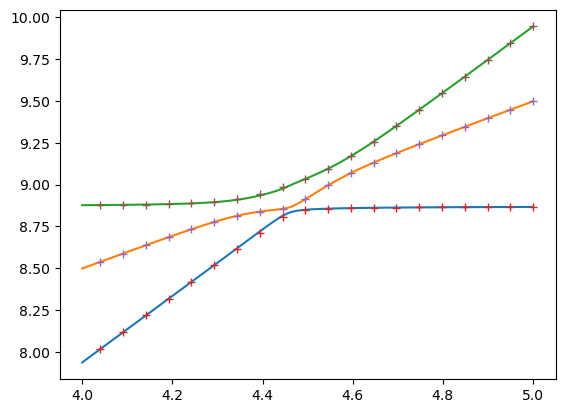

In [139]:
h4_diag = np.array([Qobj(h).diag() for h in h4_list]).T
plt.plot(freq_c_sweep, h4_diag[0])
plt.plot(freq_c_sweep, h4_diag[1])
plt.plot(freq_c_sweep, h4_diag[2])

plt.plot(freq_c_sweep[::5], energies_mat[0][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[1][::5], '+')
plt.plot(freq_c_sweep[::5], energies_mat[2][::5], '+')


plt.show()

In [140]:
h4_list[70]

array([[ 8.51782292e+00+0.j, -7.13632375e-04+0.j,  2.17094514e-02+0.j],
       [-7.13632375e-04+0.j,  8.77624579e+00+0.j,  4.44089210e-16+0.j],
       [ 2.17094514e-02+0.j,  0.00000000e+00+0.j,  8.89471917e+00+0.j]])

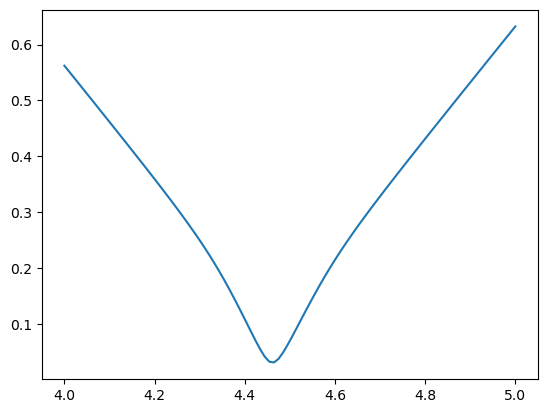

In [141]:
plt.plot(freq_c_sweep, h4_diag[1] - h4_diag[0])
plt.show()


In [142]:
import sympy as sp

# 定义符号变量
a, b, c, d, e, f, g, h, i = sp.symbols('a b c d e f g h i')

# 构造 3x3 矩阵
M = sp.Matrix([[a, 0, 1], 
               [0, -a, 1], 
               [1, 1, b]])

# 求解本征值
eigenvalues = M.eigenvals()

# 输出结果
eigenvalues

{b/3 - (3*a**2 + b**2 + 6)/(3*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)) - (27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)/3: 1,
 b/3 - (3*a**2 + b**2 + 6)/(3*(-1/2 + sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)) - (-1/2 + sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)/3: 1,
 b/3 - (3*a**2 + b**2 + 6)/(3*(-1/2 - sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)/3: 1}

In [143]:
eigenvalues


{b/3 - (3*a**2 + b**2 + 6)/(3*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)) - (27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)/3: 1,
 b/3 - (3*a**2 + b**2 + 6)/(3*(-1/2 + sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)) - (-1/2 + sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)/3: 1,
 b/3 - (3*a**2 + b**2 + 6)/(3*(-1/2 - sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(27*a**2*b/2 - b**3 + 9*b*(-a**2 - 2)/2 + sqrt(-4*(3*a**2 + b**2 + 6)**3 + (27*a**2*b - 2*b**3 + 9*b*(-a**2 - 2))**2)/2)**(1/3)/3: 1}

In [144]:
M = sp.Matrix([[a, 1], 
               [1, -a]])

# 求解本征值
eigenvalues = M.eigenvals()

# 输出结果
eigenvalues

{-sqrt(a**2 + 1): 1, sqrt(a**2 + 1): 1}